# Introduction

`pandora-sat` is a respository for information about the Pandora spacecraft, its detectors, and its orbit. It holds information on the spacecraft that is independent of pointing and target. This package is continually updated with the most current information on Pandora.

In [1]:
import pandorasat as ps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
plt.style.use(ps.PANDORASTYLE)

You can initialize the observatory using

In [2]:
p = ps.PandoraSat()

This object acts as a container of the different observatory components: the visible detector (VISDA), the NIR detector (NIRDA), the optics and hardware of the spacecraft (Hardware), and the orbit of the spacecraft (Orbit). You can access each of these components via the following

In [3]:
visda = p.VISDA
nirda = p.NIRDA
hardware = p.Hardware
orbit = p.Orbit

Each of these objects contains information on each of their respective components. Many of these are very useful quantities such as the pixel_scale of the detectors or the period of the orbit. For example, we can take a look at some of this info using

In [4]:
# This will print the pixel scale of the NIR detector
print(p.NIRDA.pixel_size)

# This will print the number of columns of the visible detector
print(p.VISDA.naxis1)
# and the number of rows of the visible detector
print(p.VISDA.naxis2)

# This will print the mirror diameter of Pandora's mirror
print(p.Hardware.mirror_diameter)

# This will print Pandora's orbital period
print(p.Orbit.period)

18.0 um / pix
2048.0 pix
2048.0 pix
0.4264141179651537 m
90.0 min


In addition to standalone values, `pandora-sat` contains useful functions that do thing such as describe the sensitivity of the detectors, convert between magnitude and flux, or estimate the throughput of a detector. Say we wanted to fetch the sensitivity of the NIR and Visible detectors then plot them for easy viewing. We would do that as follows

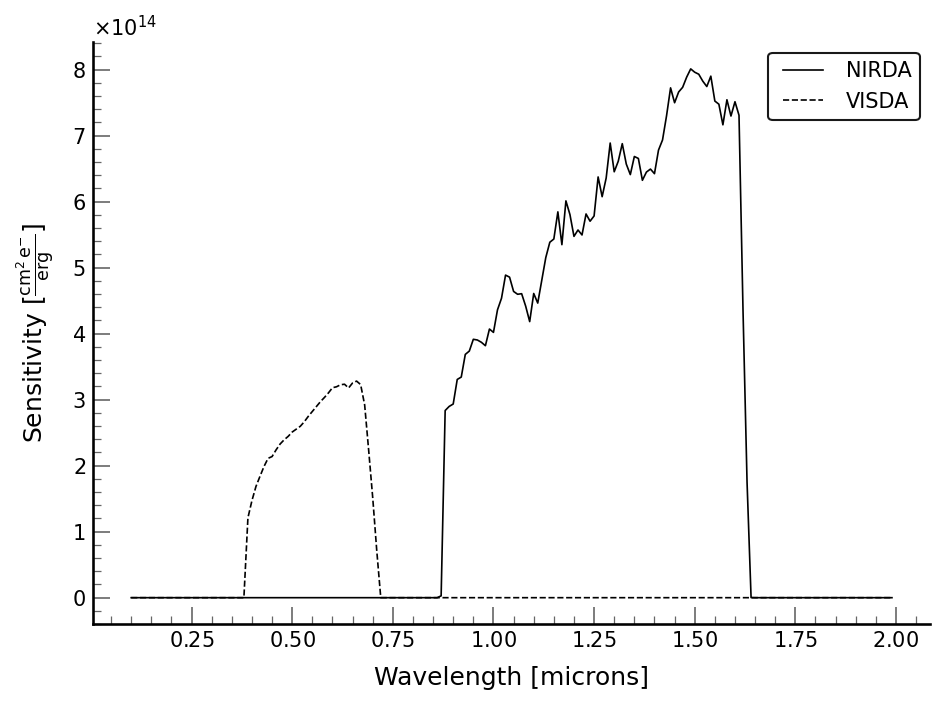

In [5]:
w = np.arange(0.1, 2, 0.01) * u.micron
fig, ax = plt.subplots()
ax.plot(w, nirda.sensitivity(w), label='NIRDA', c='k', ls='-')
ax.plot(w, visda.sensitivity(w), label='VISDA', c='k', ls='--')
ax.set(xlabel='Wavelength [microns]', ylabel=f"Sensitivity [{nirda.sensitivity(w).unit.to_string('latex')}]")
plt.legend()

Likewise, we can plot the throughput of the two detectors across the same wavelength regime like so

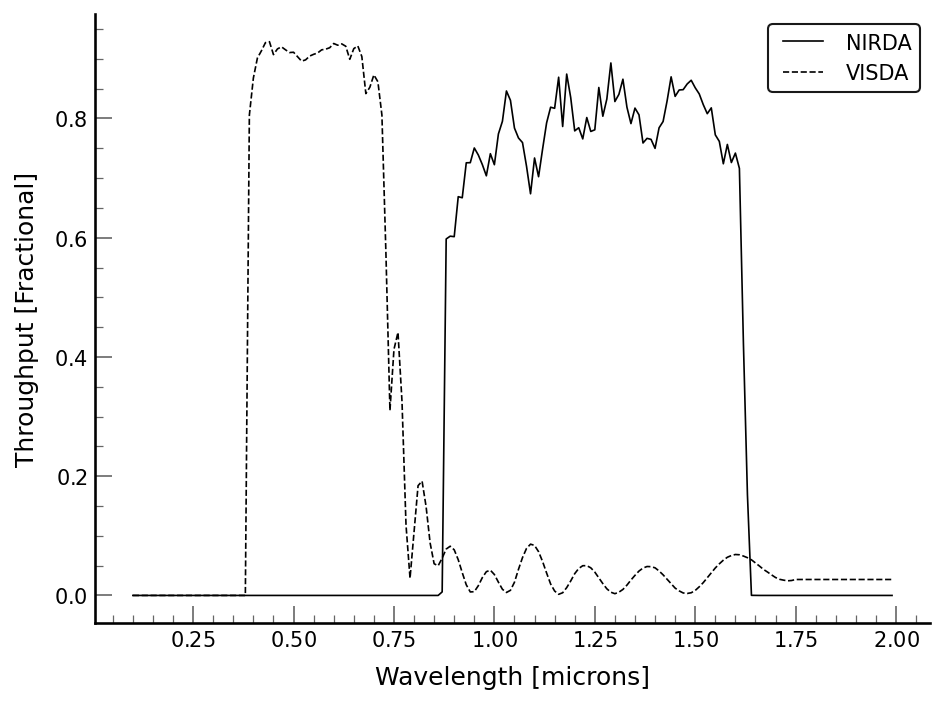

In [6]:
fig, ax = plt.subplots()
ax.plot(w, nirda.throughput(w), label='NIRDA', c='k', ls='-')
ax.plot(w, visda.throughput(w), label='VISDA', c='k', ls='--')
ax.set(xlabel='Wavelength [microns]', ylabel=f"Throughput [Fractional]")
plt.legend()

`pandora-sat` also includes a grid of phoenix models that you can use to model stars. 

In [7]:
wav, sed = ps.utils.SED(5777, jmag=14)

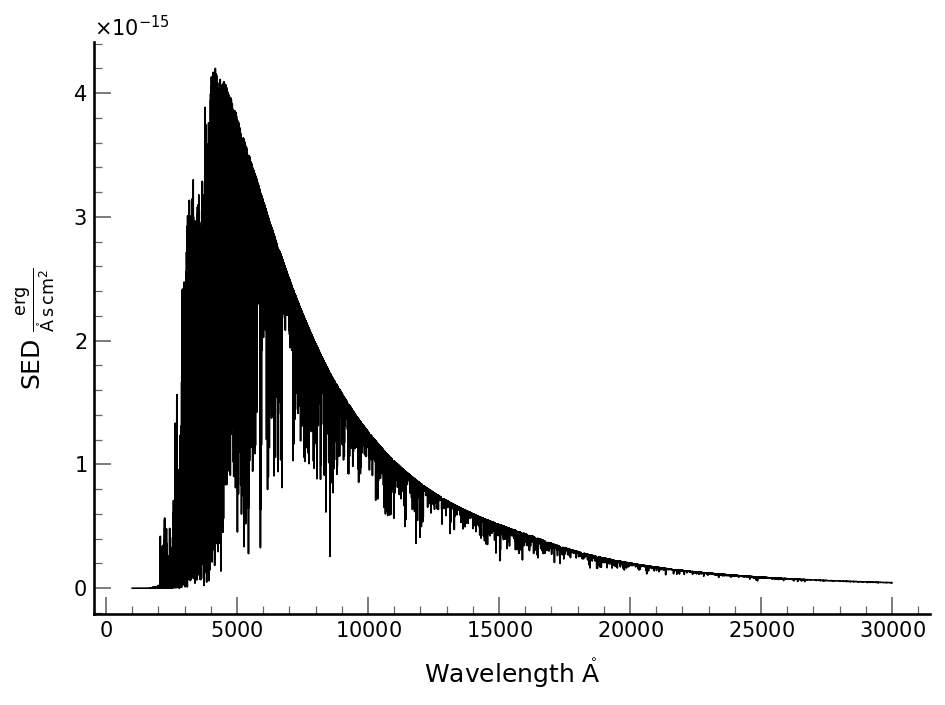

In [8]:
fig, ax = plt.subplots()
ax.plot(wav, sed)
ax.set(xlabel=f"Wavelength {wav.unit.to_string('latex')}", ylabel=f"SED {sed.unit.to_string('latex')}");

## Calculating SNR

We can calculate the flux from this SED by multiplying by the sensitivity of the instrument, and then integrating across wavelength. 

!!! note "Flux vs. Flux density"
    
    The SED of a star represents flux density, how much flux is emitted per wavelength element. We convert this to a flux by integrating over wavelength. In our case flux can have units of electrons per second, or ergs per second per square centimeter.

In [9]:
flux = np.trapz((sed * visda.sensitivity(wav)), wav)
flux

<Quantity 2442.60310934 electron / s>

This is the signal we expect for a 14th magnitude sun like star. We can use this to estimate the SNR for a source on the visible channel. Let's assume we want to know the signal to noise for this source after integrating for 2 minutes.

In [10]:
time = 120 * u.second

This corresponds to a number of integrations. For the visible channel this is

In [11]:
nints = time/visda.integration_time

We assume the source is recorded on a few pixels. You can use `pandora-psf` to understand how many pixels the source falls on, but for this simple test let's assume the PSF is ~five pixels. To get a more realistic SNR calculation, we would need to use `pandora-psf` or `pandora-sim` but this will give us a ball park.

In [12]:
npixels = 5 * u.pixel

We can then include all the noise terms that we want to model. For the visible detector this is the background rate, and the dark current rate. We also include the Poisson noise from the source.

In [13]:
rate_noise = (npixels * visda.background_rate) * time + (npixels * visda.dark_rate) * time 
rate_noise +=  ((flux.value**0.5) * flux.unit) * time

We also need to model the read noise, which applies to every integration.

In [14]:
read_noise = (visda.read_noise * npixels) * nints

We can then add these and calculate the signal to noise ratio.

In [15]:
noise = (rate_noise**2 + read_noise**2)**0.5
SNR = (flux * time)/noise

In [16]:
SNR

<Quantity 32.76807396>

Now we know given our assumptions we will detect this source on the visible channel with an SNR of ~35 in 2 minutes of integrations. 

## Calculating Magnitude

`pandora-sat` provides a Vega mag zeropoint for the detector, and it's midpoint

In [17]:
visda.zeropoint

<Quantity 3.76750833e-09 erg / (Angstrom s cm2)>

In [18]:
visda.midpoint

<Quantity 0.55905542 micron>

The zeropoint converts flux to magnitude in the Pandora bandpass.

In [19]:
flux = np.trapz((sed * visda.sensitivity(wav)), wav)
flux

<Quantity 2442.60310934 electron / s>

In [20]:
visda.flux_to_mag(flux)

<Quantity 15.27322738>

Here we have converted a flux in electrons per second to a magnitude. We can also convert a flux density which represents the average flux density in the bandpass to a magnitude:

In [21]:
normalized_sensitivity = visda.sensitivity(wav)/np.trapz(visda.sensitivity(wav), wav)

In [22]:
avg_flux_density = np.trapz((sed * normalized_sensitivity), wav)
avg_flux_density

<Quantity 2.92925193e-15 erg / (Angstrom s cm2)>

Below I plot the SED for the star and overlay the normalized sensitivity of the instrument. You can see that the average flux density the average SED through the sensitivity of the instrument.

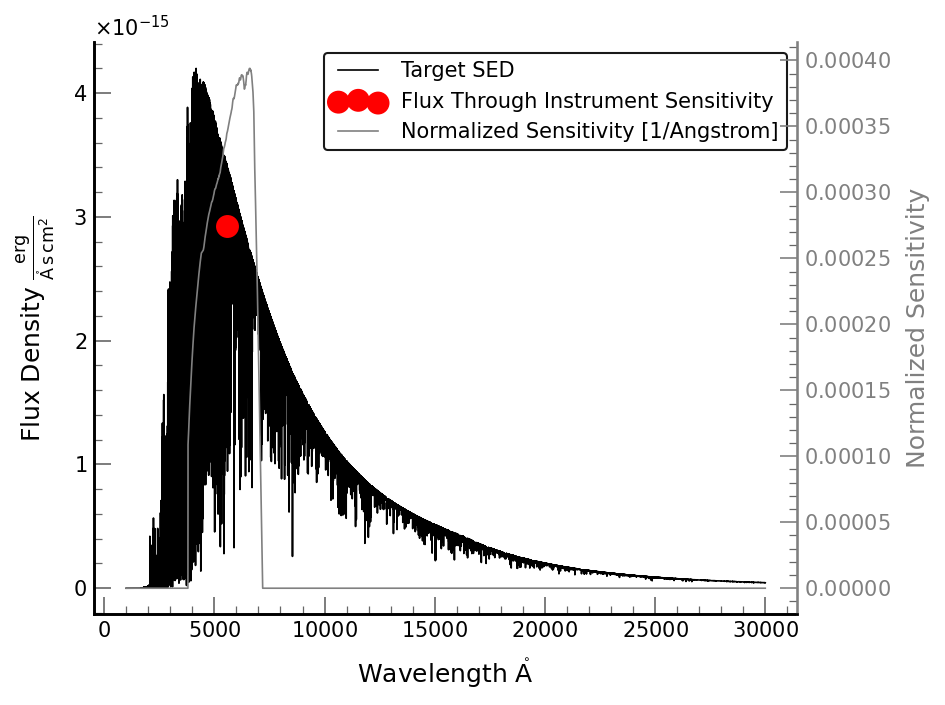

In [23]:
fig, ax1 = plt.subplots()

ax1.plot(wav, sed, label='Target SED')
ax1.scatter(visda.midpoint.to(wav.unit),
            avg_flux_density,
            c='r', 
            s=100, 
            zorder=10, 
            label='Flux Through Instrument Sensitivity')

ax1.set_xlabel(f"Wavelength {wav.unit.to_string('latex')}")
ax1.set_ylabel(f"Flux Density {sed.unit.to_string('latex')}")

ax2 = ax1.twinx()
# Plot normalized_sensitivity on the new y-axis
ax2.plot(wav, normalized_sensitivity, label='Normalized Sensitivity [1/Angstrom]', c='gray')
ax2.set_ylabel("Normalized Sensitivity")
ax2.spines["right"].set_color("gray")
ax2.spines['right'].set_visible(True)
ax2.tick_params(axis='y', colors="gray")
ax2.yaxis.label.set_color("gray")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.show()

We can convert this into a magnitude inside the Pandora band

In [24]:
visda.average_flux_density_to_mag(avg_flux_density)

<Quantity 15.27324374>

Alternatively we can convert a magnitude to an average flux density estimate

In [25]:
visda.mag_to_average_flux_density(15.27)

<Quantity 2449.87461431 electron / s>

Similarly you can convert flux to magnitude, and magnitude to flux

In [26]:
visda.mag_to_flux(15.27)

<Quantity 2449.87461431 electron / s>

In [27]:
visda.flux_to_mag(2679*u.electron/u.second)

<Quantity 15.17292786>

## Calculating SNR vs magnitude

Using the above techniques, we can calculate this for a range of magnitudes and times.

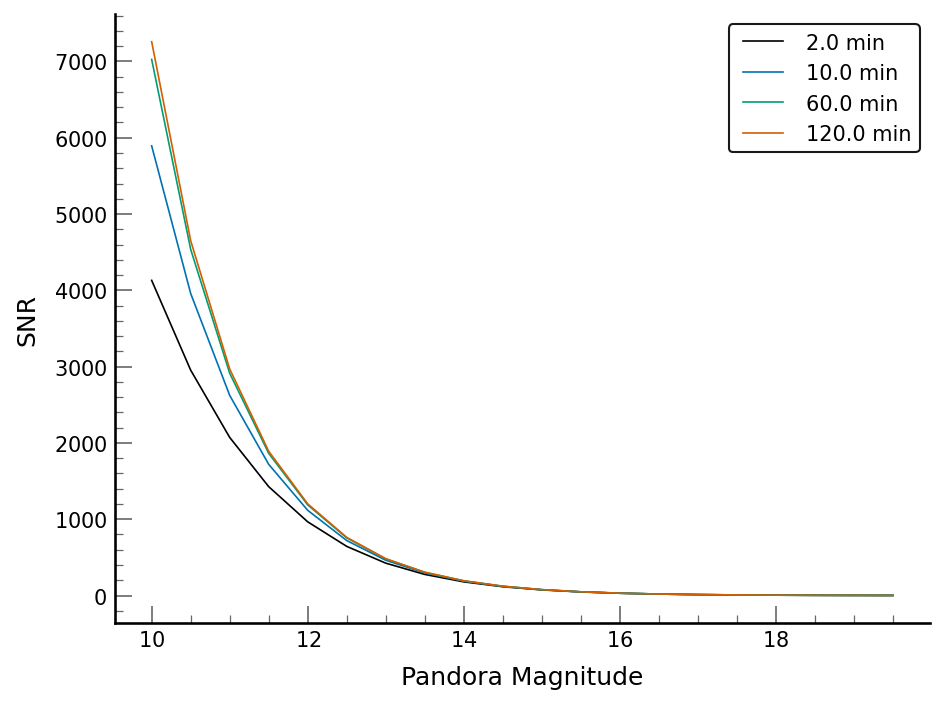

In [28]:
fig, ax = plt.subplots()
mags = np.arange(10, 20, 0.5)
npixels = 5 * u.pixel
for time in np.asarray([2, 10, 60, 120])*u.minute:
    nints = time.to(u.second)/visda.integration_time
    flux = visda.mag_to_flux(mags)* time.to(u.second)
    rate_noise = (flux.value**0.5) * flux.unit
    rate_noise += npixels * visda.background_rate * time.to(u.second)
    rate_noise += npixels * visda.dark_rate * time.to(u.second)
    read_noise = (visda.read_noise * npixels) * nints
    noise = (rate_noise**2 + read_noise**2)**0.5
    SNR = (flux)/noise
    ax.plot(mags, SNR, label=time.to_string())
ax.set(xlabel='Pandora Magnitude', ylabel='SNR')
ax.legend()

This is the SNR for a given **Pandora** magnitude. Remember you can convert your SED to a Pandora magnitude by integrating. If, for example, you only know the v band magnitude of the target, you will need to create an SED with units of `erg / (Angstrom cm^2 s)` or equivalent and then integrate through the Pandora sensitivity curve. You can create your SED in any fashion, and then find the Pandora magnitude:

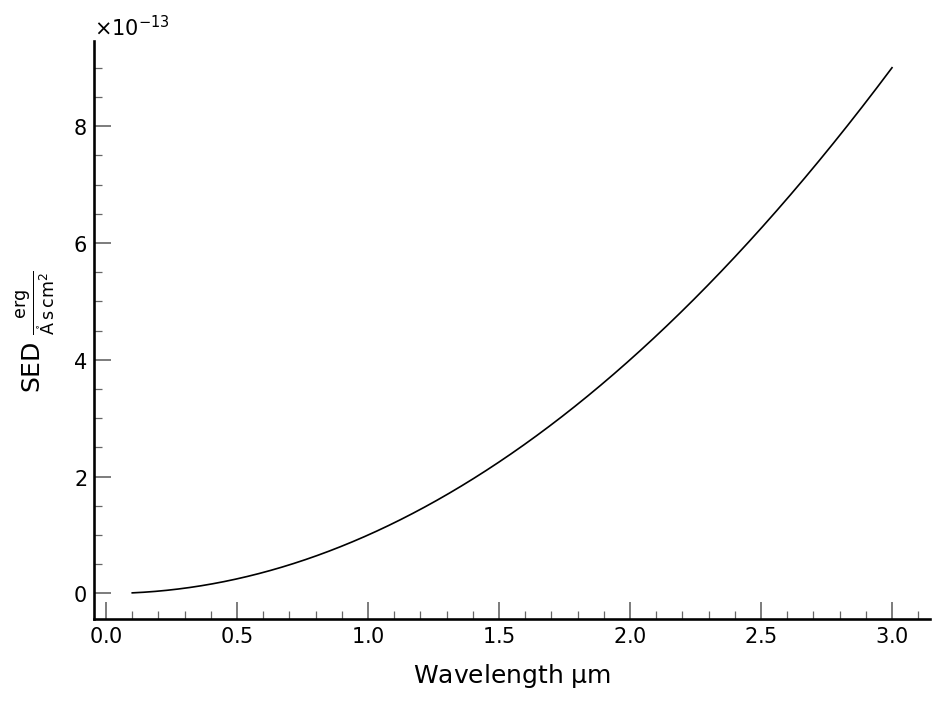

In [29]:
wav = np.linspace(0.1, 3, 10000) *u.micron
sed = 1e-13 * wav.value**2 * (u.erg / u.AA / u.s / u.cm**2)
fig, ax = plt.subplots()
ax.plot(wav, sed)
ax.set(xlabel=f"Wavelength {wav.unit.to_string('latex')}", ylabel=f"SED {sed.unit.to_string('latex')}");

In [30]:
flux = np.trapz(sed * visda.sensitivity(wav), wav).to(u.electron/u.second)
visda.flux_to_mag(flux)

<Quantity 12.67500846>

Here I have made an SED that is unphysical, and estimated the magnitude. Given our plot above, we expect such a source to be observable by Pandora with an SNR ~1000.